Training agent with decaying epsilon-greedy strategy and experience replay...


Training Progress: 100%|██████████| 15000/15000 [00:06<00:00, 2321.54it/s]


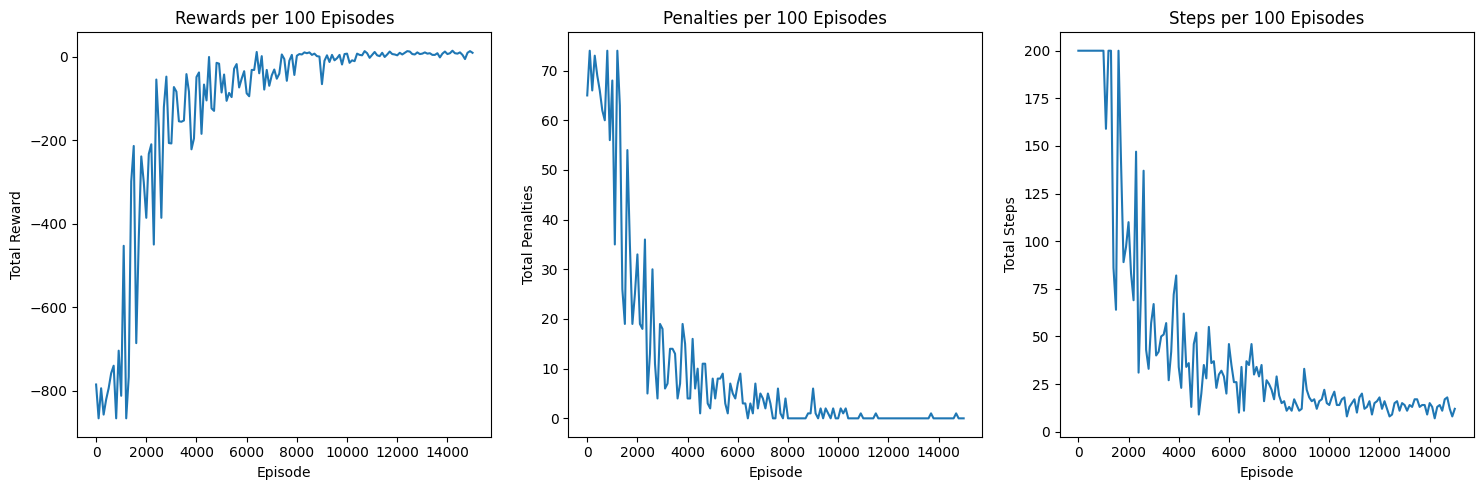

Model saved to taxi_q_table.npy

Evaluating agent performance...

Evaluation Results:
Average reward: 6.00
Average penalties: 0.00
Average steps: 15.00


In [ ]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
import time
from tqdm import tqdm  # For progress bars


# Autonomous TAXI Jesse Jesse Luca Samii
# 1. Decaying Epsilon-Greedy Strategy
# 2. Experience Replay
# 3. Optimized Parameters
# 4. Performance Visualization

class TaxiAgent:
    def __init__(self, env, buffer_size=10000):
        self.env = env
        self.q_table = np.zeros([env.observation_space.n, env.action_space.n])
        
        # Hyperparameters - tuned for better performance
        self.alpha_start = 0.5      # Initial learning rate
        self.alpha_end = 0.1        # Final learning rate
        self.gamma = 0.99           # Discount factor - increased for longer-term planning
        self.epsilon_start = 1.0    # Initial exploration rate (100% random actions)
        self.epsilon_end = 0.01     # Final exploration rate (1% random actions)
        
        # Experience replay buffer
        self.replay_buffer = deque(maxlen=buffer_size)
        self.batch_size = 32        # Number of experiences to sample in each replay
        
        # Metrics for tracking progress
        self.rewards_history = []
        self.penalties_history = []
        self.steps_history = []
    
    def get_decay_rates(self, current_episode, total_episodes):
        """Calculate decayed epsilon and alpha values based on training progress"""
        # Linear decay from start to end values
        progress = min(1.0, current_episode / (total_episodes * 0.8))  # 80% of training for full decay
        
        epsilon = self.epsilon_start - progress * (self.epsilon_start - self.epsilon_end)
        alpha = self.alpha_start - progress * (self.alpha_start - self.alpha_end)
        
        return epsilon, alpha
    
    def select_action(self, state, epsilon):
        """Select action using epsilon-greedy policy"""
        if random.uniform(0, 1) < epsilon:
            return self.env.action_space.sample()  # Explore: random action
        else:
            return np.argmax(self.q_table[state])  # Exploit: best known action
    
    def store_experience(self, state, action, reward, next_state, done):
        """Store experience in replay buffer"""
        self.replay_buffer.append((state, action, reward, next_state, done))
    
    def replay_experiences(self, alpha, gamma, batch_size=None):
        """Learn from random samples from the replay buffer"""
        if batch_size is None:
            batch_size = self.batch_size
            
        # Only replay if we have enough experiences
        if len(self.replay_buffer) < batch_size:
            return
            
        # Sample random batch of experiences
        batch = random.sample(self.replay_buffer, batch_size)
        
        for state, action, reward, next_state, done in batch:
            # Current Q-value
            current_q = self.q_table[state, action]
            
            # Target Q-value
            if done:
                target_q = reward
            else:
                target_q = reward + gamma * np.max(self.q_table[next_state])
            
            # Update Q-value with weighted average
            self.q_table[state, action] = (1 - alpha) * current_q + alpha * target_q
    
    def train(self, episodes=20000):
        """Train the agent"""
        for episode in tqdm(range(episodes), desc="Training Progress"):
            state, _ = self.env.reset()
            done = False
            total_reward = 0
            penalties = 0
            steps = 0
            
            # Get decayed parameters for this episode
            epsilon, alpha = self.get_decay_rates(episode, episodes)
            
            while not done:
                # Select action
                action = self.select_action(state, epsilon)
                
                # Take action
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                
                # Store experience
                self.store_experience(state, action, reward, next_state, done)
                
                # Update metrics
                total_reward += reward
                steps += 1
                if reward == -10:
                    penalties += 1
                
                # Move to next state
                state = next_state
            
            # Learn from experiences after each episode
            self.replay_experiences(alpha, self.gamma)
            
            # Save metrics every 100 episodes
            if episode % 100 == 0 or episode == episodes - 1:
                self.rewards_history.append(total_reward)
                self.penalties_history.append(penalties)
                self.steps_history.append(steps)
        
        return self.q_table
    
    def evaluate(self, episodes=10, render=True, delay=0.3):
        """Evaluate the trained agent"""
        if render:
            # Create a new environment with rendering for evaluation
            eval_env = gym.make("Taxi-v3", render_mode="human")
        else:
            eval_env = self.env
            
        total_rewards = 0
        total_penalties = 0
        total_steps = 0
        
        for _ in range(episodes):
            state, _ = eval_env.reset()
            done = False
            episode_reward = 0
            penalties = 0
            steps = 0
            
            while not done:
                # Always select best action during evaluation
                action = np.argmax(self.q_table[state])
                
                # Take action
                state, reward, terminated, truncated, _ = eval_env.step(action)
                done = terminated or truncated
                
                episode_reward += reward
                steps += 1
                if reward == -10:
                    penalties += 1
                    
                # Add delay for better visualization
                if render and delay > 0:
                    time.sleep(delay)
            
            total_rewards += episode_reward
            total_penalties += penalties
            total_steps += steps
        
        # Return average metrics
        return {
            "avg_reward": total_rewards / episodes,
            "avg_penalties": total_penalties / episodes,
            "avg_steps": total_steps / episodes
        }
    
    def plot_training_progress(self):
        """Plot the training progress metrics"""
        episodes = range(0, len(self.rewards_history) * 100, 100)
        
        plt.figure(figsize=(15, 5))
        
        # Plot rewards
        plt.subplot(1, 3, 1)
        plt.plot(episodes, self.rewards_history)
        plt.title('Rewards per 100 Episodes')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        
        # Plot penalties
        plt.subplot(1, 3, 2)
        plt.plot(episodes, self.penalties_history)
        plt.title('Penalties per 100 Episodes')
        plt.xlabel('Episode')
        plt.ylabel('Total Penalties')
        
        # Plot steps
        plt.subplot(1, 3, 3)
        plt.plot(episodes, self.steps_history)
        plt.title('Steps per 100 Episodes')
        plt.xlabel('Episode')
        plt.ylabel('Total Steps')
        
        plt.tight_layout()
        plt.show()
        
    def save_model(self, filename="taxi_q_table.npy"):
        """Save the Q-table to a file"""
        np.save(filename, self.q_table)
        print(f"Model saved to {filename}")
        
    def load_model(self, filename="taxi_q_table.npy"):
        """Load the Q-table from a file"""
        try:
            self.q_table = np.load(filename)
            print(f"Model loaded from {filename}")
        except FileNotFoundError:
            print(f"No model found at {filename}")


def main():
    # Setup environment
    env = gym.make("Taxi-v3")
    
    # Create and train agent
    agent = TaxiAgent(env)
    print("Training agent with decaying epsilon-greedy strategy and experience replay...")
    agent.train(episodes=15000)  # Reduced episodes as this method converges faster
    
    # Plot training progress
    agent.plot_training_progress()
    
    # Save model
    agent.save_model()
    
    # Evaluate agent
    print("\nEvaluating agent performance...")
    metrics = agent.evaluate(episodes=5, delay=0.5)
    
    print("\nEvaluation Results:")
    print(f"Average reward: {metrics['avg_reward']:.2f}")
    print(f"Average penalties: {metrics['avg_penalties']:.2f}")
    print(f"Average steps: {metrics['avg_steps']:.2f}")


if __name__ == "__main__":
    main()